In [29]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

from IPython.display import clear_output
import sys

sys.path.append('..')  # Add parent directory to path

from utils.hyperparam_vis import XgbMetricsVisualizer

In [30]:
label_encoder = LabelEncoder()

df = pd.read_csv('../Data/Processed Data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 92 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rowid               9564 non-null   int64  
 1   koi_disposition     9564 non-null   object 
 2   koi_score           9564 non-null   float64
 3   koi_fpflag_nt       9564 non-null   int64  
 4   koi_fpflag_ss       9564 non-null   int64  
 5   koi_fpflag_co       9564 non-null   int64  
 6   koi_fpflag_ec       9564 non-null   int64  
 7   koi_period          9564 non-null   float64
 8   koi_time0bk         9564 non-null   float64
 9   koi_time0           9564 non-null   float64
 10  koi_impact          9564 non-null   float64
 11  koi_impact_err1     9564 non-null   float64
 12  koi_impact_err2     9564 non-null   float64
 13  koi_duration        9564 non-null   float64
 14  koi_duration_err1   9564 non-null   float64
 15  koi_duration_err2   9564 non-null   float64
 16  koi_de

In [31]:
df['koi_disposition_encoded'] = label_encoder.fit_transform(df['koi_disposition'])

print("Original classes:", df['koi_disposition'].unique())
print("Encoded classes:", df['koi_disposition_encoded'].unique())
print("Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Original classes: ['CONFIRMED' 'CANDIDATE' 'FALSE POSITIVE']
Encoded classes: [1 0 2]
Mapping: {'CANDIDATE': np.int64(0), 'CONFIRMED': np.int64(1), 'FALSE POSITIVE': np.int64(2)}


{'validation_0': OrderedDict([('merror', [0.08154730789336122, 0.07684265551489806, 0.07213800313643493, 0.07318348144276006, 0.06952430737062205, 0.06847882906429692, 0.06847882906429692, 0.06795608991113435, 0.06325143753267119, 0.06272869837950862, 0.06168322007318348, 0.06220595922634605, 0.06429691583899634, 0.06168322007318348, 0.06011500261369577, 0.06116048092002091, 0.05906952430737062, 0.0575013068478829, 0.0575013068478829, 0.0575013068478829, 0.05854678515420805, 0.05697856769472034, 0.05488761108207005, 0.05541035023523262, 0.05384213277574491, 0.05384213277574491, 0.05488761108207005]), ('mlogloss', [0.7825700187334139, 0.5970886410123942, 0.47595213606790043, 0.39486262932131566, 0.33342316467071537, 0.2901598261528095, 0.2579123640108719, 0.23446959158589686, 0.21606032673602507, 0.20241096262930577, 0.1915707156067968, 0.18348813127342686, 0.17781255523622097, 0.17376285532739655, 0.16946253307081927, 0.1673182362738765, 0.16455792110988757, 0.16118125242857342, 0.1596

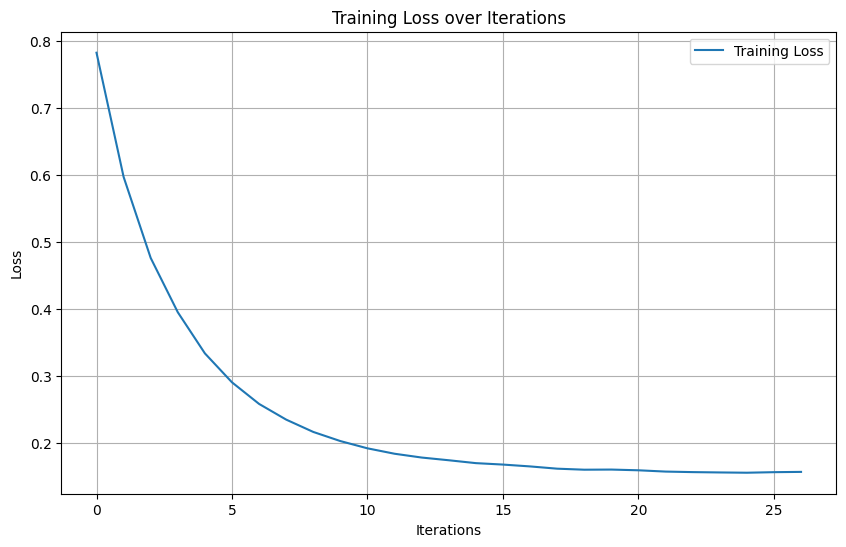

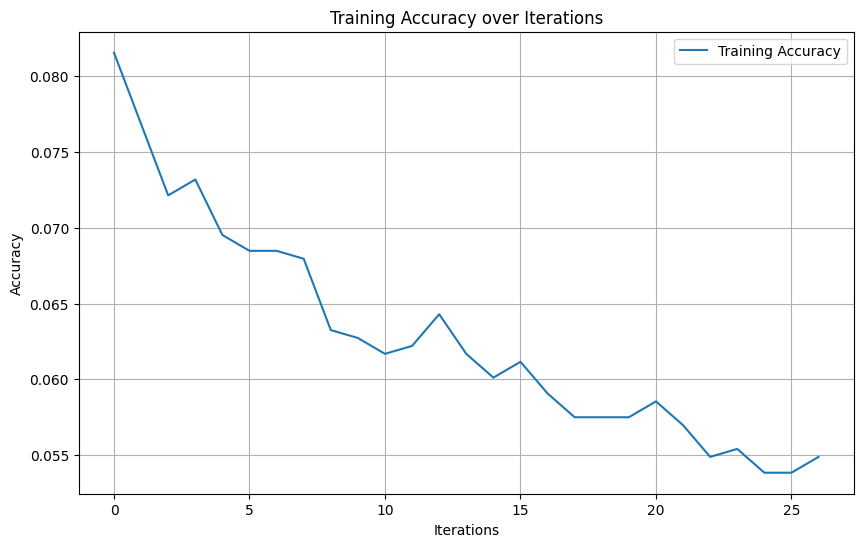

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['koi_disposition', 'koi_disposition_encoded'], axis=1), 
    df['koi_disposition_encoded'], 
    test_size=0.2, 
    random_state=42
)

# Replace your current model fitting code with this:
xgb_model1 = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, n_estimators=100, eval_metric=['merror', 'mlogloss'], random_state=42)

# Simply use verbose=True or fit without the callback
xgb_model1.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# After training, get evaluation results from the model
eval_result = xgb_model1.evals_result_
print(eval_result)

test_acc = [1 - err for err in eval_result['validation_0']['merror']]

# Now you can use your visualizer
met_vis = XgbMetricsVisualizer(xgb_model1)
met_vis.visualize_metrics(loss_history=eval_result['validation_0']['mlogloss'], accuracy_history=eval_result['validation_0']['merror'])


Accuracy: 0.9462

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       405
           1       0.91      0.93      0.92       569
           2       0.99      0.99      0.99       939

    accuracy                           0.95      1913
   macro avg       0.93      0.93      0.93      1913
weighted avg       0.95      0.95      0.95      1913



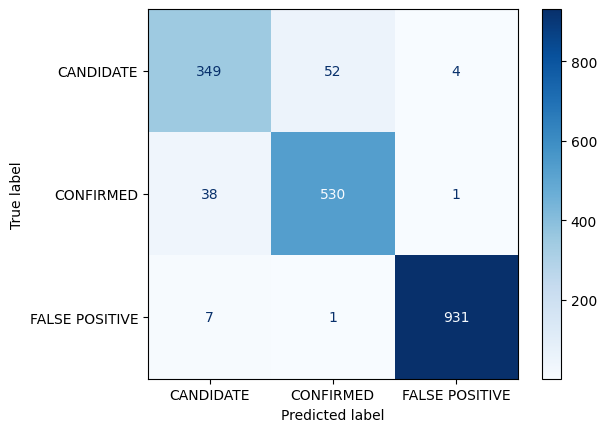

In [ ]:
y_pred = xgb_model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.show()

# Convert numeric predictions back to original labels for better interpretability
y_pred_labels = label_encoder.inverse_transform(y_pred.astype(int))
y_test_labels = label_encoder.inverse_transform(y_test.astype(int))


### HYPERMPARAMETER OPTIMIZATION HESAABI

In [ ]:
from scipy.stats import uniform, randint

parameter_grid = {
    'n_estimators': randint(100, 1000),  # Ağaç sayısı
    'max_depth': randint(3, 10),        # Maksimum ağaç derinliği
    'learning_rate': uniform(0.01, 0.3), # Öğrenme oranı
    'subsample': uniform(0.6, 0.4),     # Örnekleme oranı
    'colsample_bytree': uniform(0.6, 0.4), # Özellik örnekleme oranı
    'gamma': uniform(0, 0.5),           # Minimum kayıp azalması
    'min_child_weight': randint(1, 10), # Minimum çocuk ağırlığı
    'reg_alpha': uniform(0, 1),         # L1 düzenlileştirme (Lasso)
    'reg_lambda': uniform(0, 1)         # L2 düzenlileştirme (Ridge)
}

grid_search = RandomizedSearchCV(
    xgb_model1,
    param_distributions=parameter_grid,
    n_iter=10,
    scoring="accuracy",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

clear_output()

In [ ]:
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Best hyperparameters: {'colsample_bytree': np.float64(0.9895022075365837), 'gamma': np.float64(0.11638567021515211), 'learning_rate': np.float64(0.03718193035984624), 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 975, 'reg_alpha': np.float64(0.5142344384136116), 'reg_lambda': np.float64(0.5924145688620425), 'subsample': np.float64(0.6185801650879991)}
Best cross-validation accuracy: 0.9471


In [ ]:
xgb_model2 = xgb.XGBClassifier(**grid_search.best_params_)

xgb_model2.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,np.float64(0.9895022075365837)
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Accuracy: 0.9441

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       405
           1       0.90      0.93      0.92       569
           2       0.99      0.99      0.99       939

    accuracy                           0.94      1913
   macro avg       0.93      0.92      0.93      1913
weighted avg       0.94      0.94      0.94      1913



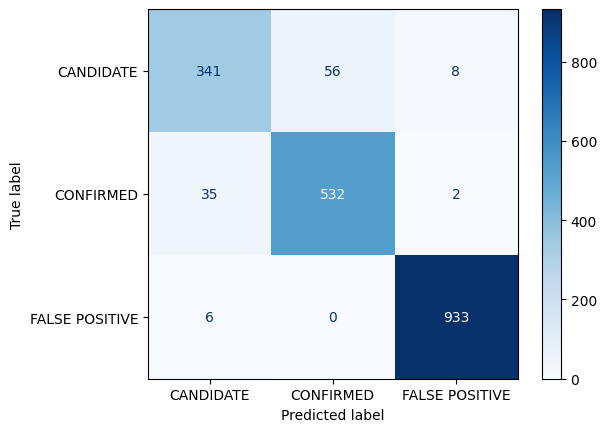

In [ ]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.show()

# Convert numeric predictions back to original labels for better interpretability
y_pred_labels = label_encoder.inverse_transform(y_pred.astype(int))
y_test_labels = label_encoder.inverse_transform(y_test.astype(int))


In [ ]:
# Import necessary library for Bayesian optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


# Define the parameter search space for Bayesian Optimization
bayes_params = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'gamma': Real(0, 0.5),
    'min_child_weight': Integer(1, 10),
    'reg_alpha': Real(0, 1.0),
    'reg_lambda': Real(0, 1.0)
}

xgb_model3 = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    xgb_model3,
    bayes_params,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=3,       # Cross-validation folds
    verbose=1,
    n_jobs=-1,  # Use all available processors
    random_state=42,
    scoring="accuracy"
)

# Fit the Bayesian optimization
print("Starting Bayesian hyperparameter optimization...")
bayes_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Print results
print(f"Best hyperparameters: {bayes_search.best_params_}")
print(f"Best cross-validation accuracy: {bayes_search.best_score_:.4f}")

# Train the model with the best parameters
bayes_model = xgb.XGBClassifier(**bayes_search.best_params_)
bayes_model.fit(X_train, y_train)


clear_output()


Bayesian Optimization Model Accuracy: 0.9446

Classification Report (Bayesian Optimization):
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       405
           1       0.90      0.94      0.92       569
           2       0.99      0.99      0.99       939

    accuracy                           0.94      1913
   macro avg       0.93      0.92      0.93      1913
weighted avg       0.94      0.94      0.94      1913



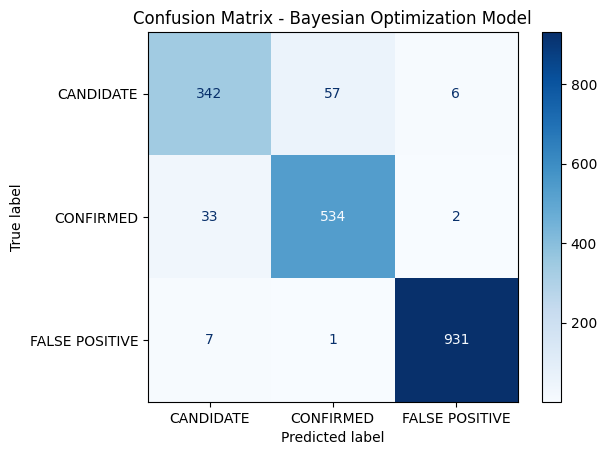

<Figure size 1000x600 with 0 Axes>

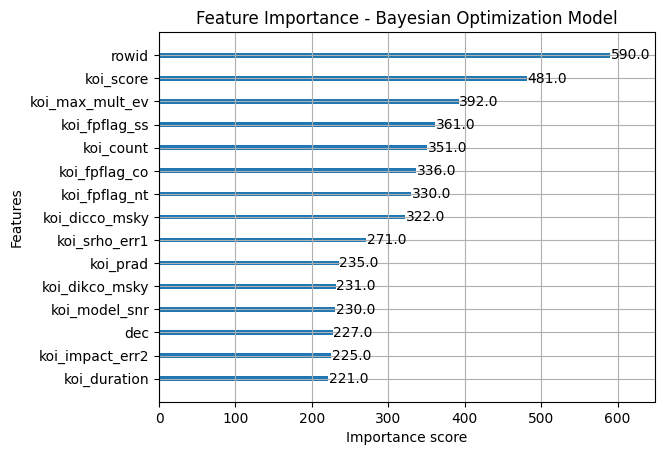

In [ ]:
# Evaluate the model
y_pred_bayes = bayes_model.predict(X_test)
accuracy_bayes = accuracy_score(y_test, y_pred_bayes)
print(f"\nBayesian Optimization Model Accuracy: {accuracy_bayes:.4f}")

print("\nClassification Report (Bayesian Optimization):")
print(classification_report(y_test, y_pred_bayes))

# Plot confusion matrix
cm_bayes = confusion_matrix(y_test, y_pred_bayes)
disp_bayes = ConfusionMatrixDisplay(confusion_matrix=cm_bayes, display_labels=label_encoder.classes_)
disp_bayes.plot(cmap='Blues')
plt.title('Confusion Matrix - Bayesian Optimization Model')
plt.show()

# Feature importance for the Bayesian-optimized model
plt.figure(figsize=(10, 6))
xgb.plot_importance(bayes_model, max_num_features=15)
plt.title('Feature Importance - Bayesian Optimization Model')
plt.show()